In [1]:
import matplotlib.pyplot as plt 
import numpy as np
import pandas as pd
import os

In [10]:
from glob import glob 
ls = glob("SensorData/*")
ls = sorted(ls)
ls

['SensorData/01 Kid IoTool sensor data_ 2022-06-28-13-19-59',
 'SensorData/02 Kid IoTool sensor data_ 2022-06-28-13-34-41',
 'SensorData/03 Adult IoTool sensor data_ 2022-06-28-13-36-26',
 'SensorData/04 Kid IoTool sensor data_ 2022-06-28-13-36-45',
 'SensorData/05 Adult IoTool sensor data_ 2022-06-28-13-39-40',
 'SensorData/06 Adult IoTool sensor data_ 2022-06-28-13-40-18',
 'SensorData/07 Kid IoTool sensor data_ 2022-06-28-13-42-19',
 'SensorData/08 09 Kid IoTool sensor data_ 2022-06-28-13-43-47',
 'SensorData/10 Kid IoTool sensor data_ 2022-06-28-13-44-23']

In [7]:
def create_dr(df):
    minn = df.index.values.min()
    maxx = df.index.values.max()
    date_range =pd.date_range(start=minn, end=maxx, freq='ms')

    return date_range

In [6]:
# from IPython.display import clear_output
import traceback
for ff in  glob(f"{ls[0]}/f*.p*"):
    print ("Processing Folder", ff)
#     z = iter(range(25))
#     set_dt = False
#     for csv in glob(f"{ff}/[!f]*.csv"):
#         # try:
#         sensor = csv.split("@")[0].split("/")[-1]
#         df = pd.read_csv(csv, header=0, names=['date','time','val'])
#         df['date'] =  df['date'] + " " + df['time']
#         df = df.drop(labels = ['time'], axis = 1)
#         df['date'] = pd.to_datetime( df['date'] )
#         df.rename(columns={'val':sensor}, inplace=True)
#         df = df.set_index(keys=['date'])
#         # print ("------------",df.columns)
#         if not set_dt:
#             date_range = create_dr(df)
#             final = pd.DataFrame(date_range, columns = ['date'])
#             set_dt = True
        
#         final = pd.merge_asof(final, df, on='date')
    
#     final = final.reindex(sorted(final.columns), axis=1)
#     final.set_index(keys=['date'], inplace=True)
#     final.to_parquet(f"{ff}/final.parquet")
#     print ("Saved------"*2,final.shape )

Processing Folder SensorData2/E01-IoTool sensor data_ 2022-08-31-13-52-03/final.parquet


In [20]:
final = pd.read_parquet(f"{ls[7]}/final.parquet")
final = final[["AccelerometerX","AccelerometerY","AccelerometerZ","GyroscopeX","GyroscopeY","GyroscopeZ"]]
# final = final[["AccelerometerAbsolute","GyroscopeAbsolute"]].diff()
final.dropna(inplace=True, how='any')
final.shape


(410907, 6)

(286692, 6)

### Signal Preprocessing 
1. Acceleration has gravtational components and body motion components, these will be separated with butterworth low pas filter in to body accelration and gravity
2. Apply Noise filters to both Accelorometer and Gyroscope sensors.


##### Butterworth Low Pass Filter

In [10]:
import numpy as np
from scipy.signal import butter, sosfilt
# Filter requirements.
cutoff = 0.8      # desired cutoff frequency of the filter, Hz ,      slightly higher than actual 1.2 Hz

In [11]:
sos = b,a = butter(
    N = 4, 
    Wn = cutoff, 
    btype='low', 
    analog=False, 
    output='sos')

In [12]:
for col in ["AccelerometerX","AccelerometerY","AccelerometerZ"]:
    final[col] = sosfilt( sos, final[col].values)

In [13]:
# import matplotlib.pyplot as plt
# plt.figure(figsize = (18,4))
# plt.plot(final['AccelerometerX'].values)
# plt.plot(dinal)
# plt.legend(["Before High Pass", " After Low Pass"])

##### Noise Filter

In [14]:
from scipy.signal import lfilter
def noise_filter(y):
    n = 2  # the larger n is, the smoother curve will be
    b = [1.0 / n] * n
    a = 1
    return lfilter(b, a, y)

In [15]:
for col in ["GyroscopeX",	"GyroscopeY",	"GyroscopeZ"]:
    final[col] = noise_filter( final[col].values )

In [16]:
final['GyroscopeAbsolute'] = np.sqrt(final[["GyroscopeX",	"GyroscopeY",	"GyroscopeZ"]].sum(axis=1)**2)
final['AccelerometerAbsolute'] = np.sqrt(final[["AccelerometerX",	"AccelerometerY",	"AccelerometerZ"]].sum(axis=1)**2)

### Applying Fourier Transform

In [17]:
from scipy.fftpack import fft
import plotly_express as px

In [18]:
x = final['GyroscopeX'].values
sr = 1/0.001
X = fft(x)
N = len(X)
n = np.arange(N)
T = N/sr
freq = n/T 


In [51]:
1/0.001

1000.0

Text(0, 0.5, 'FFT Amplitude |X(freq)|')

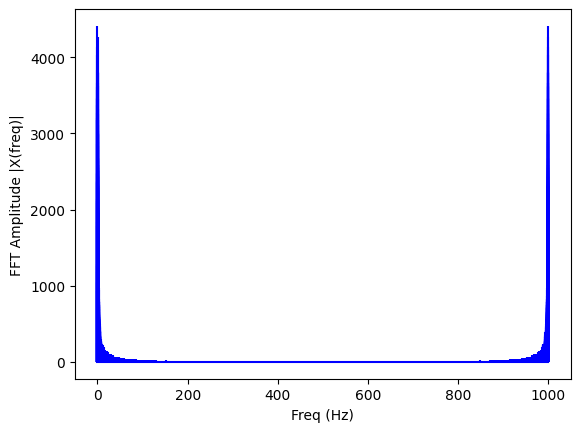

In [19]:
plt.stem( freq, np.abs(X),
        # log_y = True,
        'b', markerfmt=" ", basefmt="-b"
         )
plt.xlabel('Freq (Hz)')
plt.ylabel('FFT Amplitude |X(freq)|')

In [76]:
df = final.resample('100ms').agg({'AccelerometerAbsolute': [np.var, np.std] , 'GyroscopeAbsolute': [np.var, np.std] })

In [77]:
df = df.T.reset_index(drop=True).T
df.columns = ['AccAbs_var','AccAbs_std','GyroAbs_var','GyroAbs_std']

<AxesSubplot: xlabel='date'>

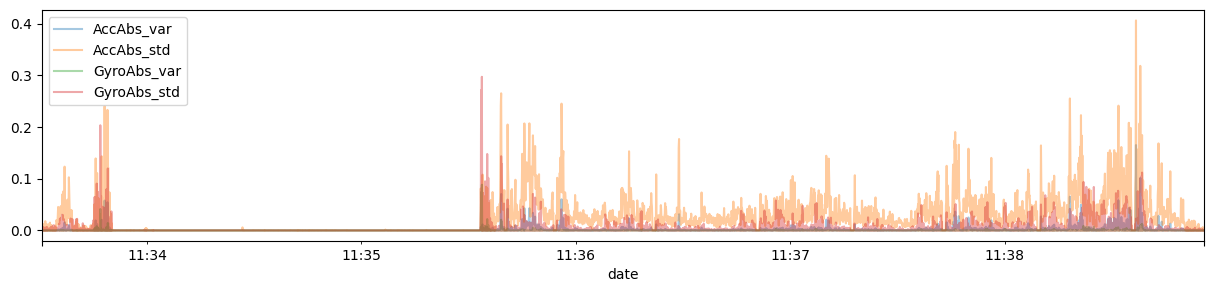

In [79]:
df.plot(alpha = 0.4, figsize = (15,3))

#### Creating Training Data

In [ ]:
window = 256
stride = window//2

In [ ]:
import numpy as np
def window_stack(a, stepsize=stride, width=window):
    n = a.shape[0]
    return np.hstack( a[i:1+n+i-width:stepsize] for i in range(0,width) )

In [ ]:
arr = window_stack(final.to_numpy(), width=window,stepsize=stride)

In [ ]:
np.lib.stride_tricks.as_strided(a, shape=(window,a.shape[1]), strides=(8,4))

In [ ]:
arr = final.to_numpy()
arr.shape

In [ ]:
111409

In [ ]:
import pandas as pd

In [ ]:
pd.rollin

### Analyzing JSON

In [12]:
import matplotlib.pyplot as plt
import json
import os

In [24]:
with open('2022_5_13 - 2023_5_13 all.json','r') as f:
    js = json.load(f)
# X = [i['Position']['X'] for i in js[0]['data']['SpatialData']['DataPoints']]
# Y = [i['Position']['Y'] for i in js[0]['data']['SpatialData']['DataPoints']]
# Z = [i['Position']['Z'] for i in js[0]['data']['SpatialData']['DataPoints']]
# t = [i['DeltaTime'] for i in js[0]['data']['SpatialData']['DataPoints']]
# df = pd.DataFrame({"time": t ,"x" : X, "y" : Y, "z" : Z})
# df['time'] = df['time'].cumsum()

In [25]:
dates = [i['data']['Created'] for i in js ]
sessions = [i['id'] for i in js ] 

In [26]:
import pandas as pd
import plotly.express as px
df = pd.DataFrame({'date':dates,'sessions':sessions })
df['date'] = pd.to_datetime(df['date'], format='%Y-%m-%d') #.dt.time
# df.date = df.date.dt.round('10s')
# df.date = df.date.dt.time

In [45]:
from datetime import date
date('2022-12-8')

TypeError: 'str' object cannot be interpreted as an integer

In [50]:
df[ df.date.between(df.date.min(), df.date.max())]

,date,sessions
0,2022-08-29 15:10:54,963cbe8d-b957-4a10-820d-fe75f0b6aaa4
1,2022-08-29 15:12:04,3171cd94-5b51-4f84-9716-cb75e6a8e2b2
2,2022-08-29 15:30:54,41d0a4ed-d8cc-4eec-8a4b-fd3448e56ef1
3,2022-08-29 15:37:00,a3dd7344-2537-440b-a735-caa96df86c47
4,2022-08-29 15:49:48,5a6053fe-2d5e-43a3-8222-d9e400a8f9e1
...,...,...
115,2023-04-22 12:31:42,f59fbd73-70c2-4ba8-849a-7f8a8c9ec1c2
116,2023-04-22 12:32:29,72c33647-f4d8-4192-a0e6-ba236615f3fa
117,2023-04-22 12:33:16,3b53f34e-2724-45f6-92a0-f3b193278d9b
118,2023-04-22 12:34:14,ca70f6fa-78a5-40fa-84ea-d1c13957f373


<AxesSubplot: xlabel='date'>

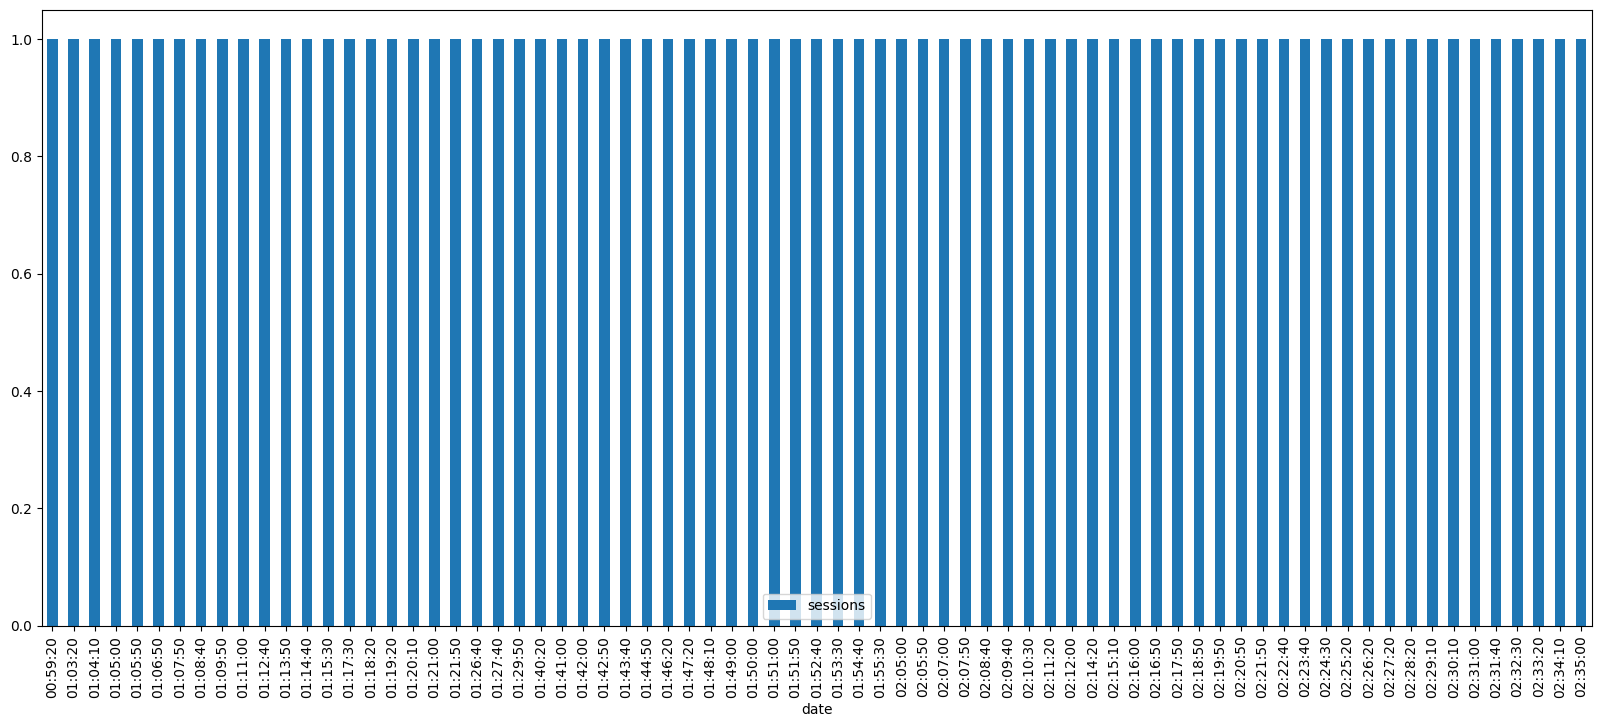

In [65]:
f,ax = plt.subplots(figsize=(20,8))
df.groupby('date').count().plot.bar(ax = ax)

In [73]:
for pos,p in enumerate(ax.patches):
    ax.annotate(df.sessions.values[pos], (p.get_x() * 1.005, p.get_height() * 1.005))

In [54]:
pos = 0
x = [i['Position']['X'] for i in js[pos]['data']['SpatialData']['DataPoints']]
y = [i['Position']['Y'] for i in js[pos]['data']['SpatialData']['DataPoints']]
z = [i['Position']['Z'] for i in js[pos]['data']['SpatialData']['DataPoints']]
X = [i['Rotation']['X'] for i in js[pos]['data']['SpatialData']['DataPoints']]
Y = [i['Rotation']['Y'] for i in js[pos]['data']['SpatialData']['DataPoints']]
Z = [i['Rotation']['Z'] for i in js[pos]['data']['SpatialData']['DataPoints']]
W = [i['Rotation']['W'] for i in js[pos]['data']['SpatialData']['DataPoints']]
t = [i['DeltaTime'] for i in js[pos]['data']['SpatialData']['DataPoints']]
df = pd.DataFrame({ "time": t ,"x" : x, "y" : y, "z" : z, 
                    "rotation_X" : X, "rotation_Y" : Y, "rotation_Z" : Z, "orientaion_W": W })
df['time'] = df['time'].cumsum()

In [55]:
df['distance'] = df[["x",  "y",	"z"]].apply(lambda x : (sum([i**2 for i in x.values]))**0.5, axis = 1 )

In [ ]:
from sklearn.preprocessing import MinMaxScaler
dis = MinMaxScaler()
ort_mx = MinMaxScaler()

 df['distance'] = dis.fit_transform(  df['distance'] )
# df[['rotation_X','rotation_Y','rotation_Z','orientaion_W']] = rot_mx.fit_transform( df[['rotation_X','rotation_Y','rotation_Z','orientaion_W']])


<AxesSubplot: >

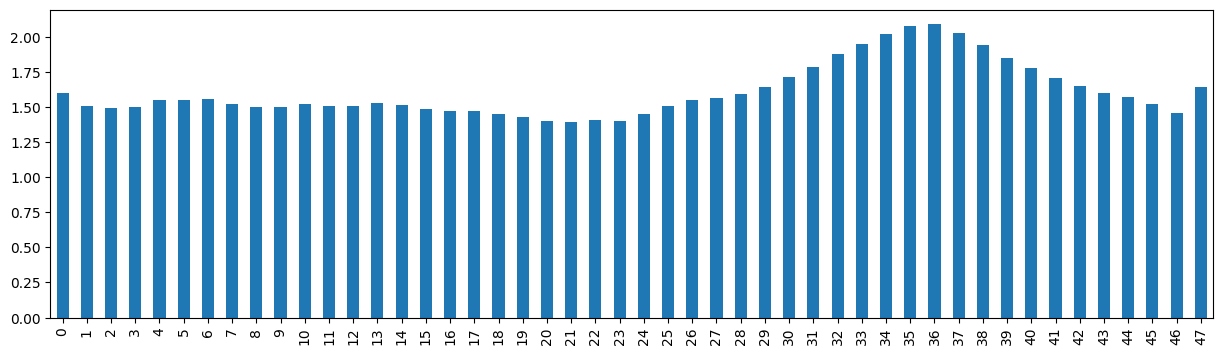

In [56]:
df['distance'].plot.bar(figsize=(15,4))

In [33]:
fig = px.line_3d(
                    data_frame = df, 
                    x = df['x'].values, 
                    y = df['y'].values, 
                    z = df['z'].values,
                    )

In [1]:
# fig.show()

In [4]:
import numpy as np
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.animation
import pandas as pd
%matplotlib qt



def update_graph(num):
    data=df[df['time']==num]
    graph.set_data (data.x, data.y)
    graph.set_3d_properties(data.z)
    title.set_text('3D Test, time={}'.format(num))
    return title, graph, 


fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
title = ax.set_title('3D Test')

data=df[df['time']!=0]
graph, = ax.plot(data.x, data.y, data.z, linestyle="", marker="o")

ani = matplotlib.animation.FuncAnimation(fig, update_graph, 19, 
                               interval=40, blit=True)

plt.show()

In [24]:
data = pd.DataFrame(np.repeat(df.values, [i for i in range(1, df.shape[0] + 1)], axis=0), columns = ['time','X','Y','Z'])
data['grp'] = [i for i in range(1,df.shape[0]+1) for j in range( i )]

In [25]:
data

,time,X,Y,Z,grp
0,12.182931,0.098998,1.308312,-0.919175,1
1,12.616250,0.085207,1.249220,-0.838226,2
2,12.616250,0.085207,1.249220,-0.838226,2
3,12.916199,0.143881,1.233740,-0.833066,3
4,12.916199,0.143881,1.233740,-0.833066,3
...,...,...,...,...,...
1171,38.748630,0.149036,1.495540,-0.660934,48
1172,38.748630,0.149036,1.495540,-0.660934,48
1173,38.748630,0.149036,1.495540,-0.660934,48
1174,38.748630,0.149036,1.495540,-0.660934,48


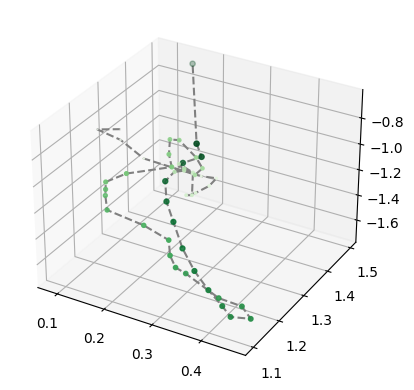

In [5]:
# Data for three-dimensional scattered points
ax = plt.axes(projection='3d')
ax.scatter3D(X, Y, Z, 
                s=[0.3*i for i in range(1,49)],
                c=[0.7*i for i in range(1,49)],
                cmap='Greens');
ax.plot3D(X, Y, Z, 'gray', linestyle='--')


In [6]:
a = np.random.rand(2000, 3)*10
t = np.array([np.ones(100)*i for i in range(20)]).flatten()
df = pd.DataFrame({"time": t ,"x" : a[:,0], "y" : a[:,1], "z" : a[:,2]})

In [7]:
df

,time,x,y,z
0,0.0,9.781245,2.242229,9.854996
1,0.0,3.498352,6.718934,8.444743
2,0.0,6.378617,2.146647,4.165051
3,0.0,7.182116,0.196138,2.164399
4,0.0,4.775268,2.058027,3.465970
...,...,...,...,...
1995,19.0,2.197177,3.009842,0.119217
1996,19.0,7.308514,0.745641,8.563885
1997,19.0,8.681806,5.694893,5.957130
1998,19.0,0.637293,0.735525,1.150208
